# 3-1,低阶API示范

下面的范例使用Pytorch的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [68]:
import datetime  # 导入datetime模块，用于处理日期和时间
import os  # 导入os模块，用于操作操作系统相关功能


# 定义一个名为printbar的函数，用于打印当前时间的分隔线
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # 获取当前时间并格式化为字符串
    print("\n" + "==========" * 8 + "%s" % nowtime)  # 打印分隔线和当前时间


# 在mac系统上，当同时运行PyTorch和Matplotlib在Jupyter中时，需要更改环境变量以避免库冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 设置环境变量KMP_DUPLICATE_LIB_OK为"TRUE"，允许重复的库加载

In [69]:
import torch

print("torch.__version__=" + torch.__version__)

torch.__version__=2.0.1


### 一，线性回归模型

**1，准备数据**

In [70]:
from matplotlib import pyplot as plt  # 导入matplotlib的pyplot模块，用于绘图
import torch  # 导入PyTorch深度学习框架

n = 400  # 定义样本数量

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  # 生成一个形状为(n, 2)的随机张量X，每个元素都在-5.0到5.0之间
w0 = torch.tensor([[2.0], [-3.0]])  # 创建一个形状为(2, 1)的张量w0，用于表示权重参数
b0 = torch.tensor([[10.0]])  # 创建一个形状为(1, 1)的张量b0，用于表示偏置参数
Y = X @ w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])
# 计算Y，这是一个矩阵乘法操作，其中X @ w0表示矩阵乘法，torch.normal用于生成正态分布的扰动
# 0.0表示均值，2.0表示标准差，size=[n, 1]表示生成一个形状为(n, 1)的张量，与X @ w0的形状相匹配


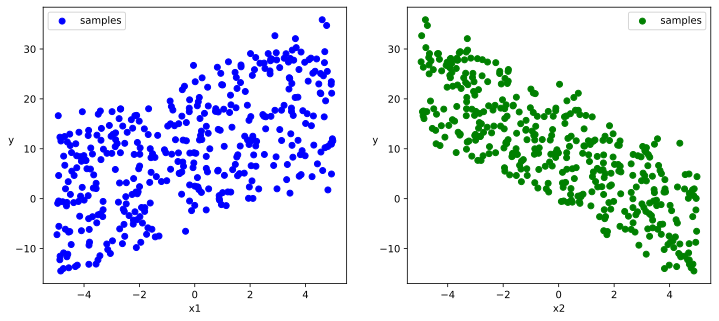

In [71]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置图形的大小为12x5英寸
plt.figure(figsize=(12, 5))

# 创建第一个子图，位于1行2列的第1个位置
ax1 = plt.subplot(121)

# 绘制散点图，X[:, 0].numpy()表示X中的第一列数据，Y[:, 0].numpy()表示Y中的第一列数据
# c="b"表示散点的颜色为蓝色，label="samples"设置图例标签
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c="b", label="samples")

# 添加图例
ax1.legend()

# 设置x轴标签为"x1"，y轴标签为"y"，rotation=0表示标签不旋转
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

# 创建第二个子图，位于1行2列的第2个位置
ax2 = plt.subplot(122)

# 绘制散点图，X[:, 1].numpy()表示X中的第二列数据，Y[:, 0].numpy()表示Y中的第一列数据
# c="g"表示散点的颜色为绿色，label="samples"设置图例标签
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c="g", label="samples")

# 添加图例
ax2.legend()

# 设置x轴标签为"x2"，y轴标签为"y"，rotation=0表示标签不旋转
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

# 显示图形
plt.show()


In [72]:
# 定义一个名为data_iter的数据管道迭代器函数，用于生成小批量的训练数据
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)  # 获取样本数量
    indices = list(range(num_examples))  # 创建样本索引列表
    np.random.shuffle(indices)  # 随机打乱样本索引，以实现随机数据顺序读取

    for i in range(0, num_examples, batch_size):
        # 创建一个名为indexs的LongTensor张量，包含每个小批量的样本索引
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])

        # 使用index_select方法从features和labels中选择对应索引的数据，并通过yield关键字生成小批量数据
        yield features.index_select(0, indexs), labels.index_select(0, indexs)


# 测试数据管道效果
batch_size = 8  # 定义小批量的大小
(features, labels) = next(data_iter(X, Y, batch_size))  # 获取第一个小批量的训练数据

# 打印特征和标签
print(features)  # 打印特征
print(labels)  # 打印标签


tensor([[ 3.0697, -3.9270],
        [-4.5162, -3.5475],
        [ 0.5025,  3.8330],
        [ 1.8255, -3.0678],
        [-1.6083, -1.5353],
        [ 4.4028, -3.9075],
        [-3.1728, -0.7232],
        [ 2.7533, -0.7703]])
tensor([[26.2703],
        [12.9333],
        [ 1.9609],
        [21.4855],
        [10.0105],
        [28.0057],
        [ 9.0938],
        [16.5072]])


**2，定义模型**

In [73]:
# 定义一个名为LinearRegression的类，用于创建线性回归模型
class LinearRegression:

    def __init__(self):
        # 在初始化函数中，创建模型参数w和b，初始值是随机生成的，并且要求计算梯度
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.zeros_like(b0, requires_grad=True)

    # 正向传播函数，用于计算模型的预测值
    def forward(self, x):
        return x @ self.w + self.b

    # 损失函数，用于计算模型的损失值
    def loss_fn(self, y_pred, y_true):
        # 计算均方误差损失，其中(y_pred - y_true)表示预测值与真实值的差异，**2表示平方，/ 2表示除以2，只是为了求导与求导后产生的2相互抵消
        return torch.mean((y_pred - y_true) ** 2 / 2)


# 创建一个名为model的线性回归模型实例
model = LinearRegression()


**3，训练模型**

In [74]:
# 定义训练步骤的函数train_step，用于执行一次训练迭代
def train_step(model, features, labels):
    # 前向传播：计算模型的预测值
    predictions = model.forward(features)

    # 计算损失值：使用模型的损失函数来评估预测值与真实值之间的差异
    loss = model.loss_fn(predictions, labels)

    # 反向传播：计算模型参数的梯度
    loss.backward()

    # 使用torch.no_grad()上下文管理器避免梯度记录，也可以通过操作model.w.data来实现避免梯度记录
    with torch.no_grad():
        # 梯度下降法更新模型参数，学习率为0.001
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad

        # 梯度清零：重置梯度以准备下一次迭代
        model.w.grad.zero_()
        model.b.grad.zero_()

    return loss  # 返回损失值，用于监控训练过程中的损失变化


In [75]:
# 测试train_step效果
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)


tensor(211.4244, grad_fn=<MeanBackward0>)

In [76]:
# 定义训练模型的函数train_model，包括多个训练周期（epochs）
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        # 在每个周期内，通过data_iter生成小批量数据，然后使用train_step函数进行模型训练
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)

        # 每20个周期打印一次损失值和模型参数
        if epoch % 20 == 0:
            printbar()
            print("epoch =", epoch, "loss =", loss.item())  # 打印当前周期的损失值
            print("model.w =", model.w.data)  # 打印模型参数w的值
            print("model.b =", model.b.data)  # 打印模型参数b的值


# 调用train_model函数进行模型训练，共200个周期
train_model(model, epochs=200)



================================================================================2023-09-06 17:17:00
epoch = 20 loss = 14.089225769042969
model.w = tensor([[ 1.9223],
        [-2.9928]])
model.b = tensor([[5.4713]])

================================================================================2023-09-06 17:17:00
epoch = 40 loss = 2.9437365531921387
model.w = tensor([[ 1.9880],
        [-2.9697]])
model.b = tensor([[7.9563]])

================================================================================2023-09-06 17:17:00
epoch = 60 loss = 1.909510850906372
model.w = tensor([[ 2.0164],
        [-2.9587]])
model.b = tensor([[9.0772]])

================================================================================2023-09-06 17:17:01
epoch = 80 loss = 0.9810901880264282
model.w = tensor([[ 2.0346],
        [-2.9557]])
model.b = tensor([[9.5827]])

================================================================================2023-09-06 17:17:01
epoch = 100 loss = 1.068971514701843

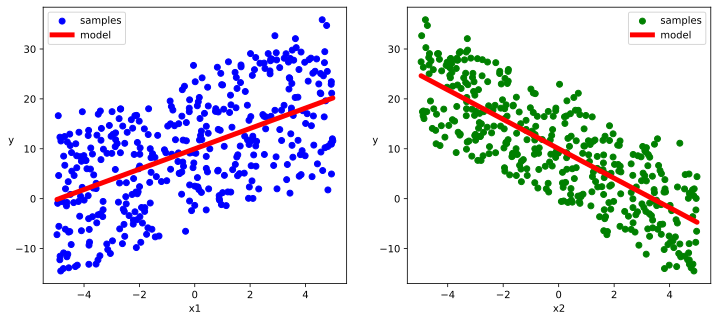

In [77]:
# 导入必要的库并设置图形格式为SVG
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 创建一个图形，设置图形大小为12x5英寸
plt.figure(figsize=(12, 5))

# 创建第一个子图，位于1行2列的第1个位置
ax1 = plt.subplot(121)

# 绘制散点图，显示原始数据点，c="b"表示散点的颜色为蓝色，label="samples"设置图例标签
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c="b", label="samples")

# 绘制模型的线性拟合曲线，使用红色直线表示，linewidth=5.0设置线宽，label="model"设置图例标签
ax1.plot(X[:, 0].numpy(), (model.w[0].data * X[:, 0] + model.b[0].data).numpy(), "-r", linewidth=5.0, label="model")

# 添加图例
ax1.legend()

# 设置x轴标签为"x1"，y轴标签为"y"，rotation=0表示标签不旋转
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

# 创建第二个子图，位于1行2列的第2个位置
ax2 = plt.subplot(122)

# 绘制散点图，显示原始数据点，c="g"表示散点的颜色为绿色，label="samples"设置图例标签
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c="g", label="samples")

# 绘制模型的线性拟合曲线，使用红色直线表示，linewidth=5.0设置线宽，label="model"设置图例标签
ax2.plot(X[:, 1].numpy(), (model.w[1].data * X[:, 1] + model.b[0].data).numpy(), "-r", linewidth=5.0, label="model")

# 添加图例
ax2.legend()

# 设置x轴标签为"x2"，y轴标签为"y"，rotation=0表示标签不旋转
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

# 显示图形
plt.show()


### 二，DNN二分类模型

**1，准备数据**

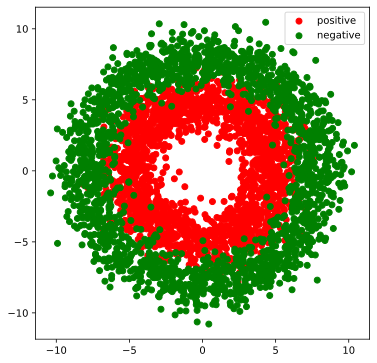

In [78]:
import numpy as np  # 导入NumPy库，用于处理数组和随机数生成
from matplotlib import pyplot as plt  # 导入Matplotlib库，用于绘图
import torch  # 导入PyTorch深度学习框架
from torch import nn  # 导入PyTorch的神经网络模块

# 设置图形格式为SVG并内联显示图形
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本，小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])  # 生成半径，加上正态分布的扰动
theta_p = 2 * np.pi * torch.rand([n_positive, 1])  # 生成角度
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)  # 构建正样本的二维坐标
Yp = torch.ones_like(r_p)  # 创建与正样本数量相同的标签，值为1表示正样本

# 生成负样本，大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])  # 生成半径，加上正态分布的扰动
theta_n = 2 * np.pi * torch.rand([n_negative, 1])  # 生成角度
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)  # 构建负样本的二维坐标
Yn = torch.zeros_like(r_n)  # 创建与负样本数量相同的标签，值为0表示负样本

# 汇总样本
X = torch.cat([Xp, Xn], axis=0)  # 合并正负样本的特征数据
Y = torch.cat([Yp, Yn], axis=0)  # 合并正负样本的标签数据

# 可视化样本分布
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c="r")  # 绘制正样本的散点图，颜色为红色
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c="g")  # 绘制负样本的散点图，颜色为绿色
plt.legend(["positive", "negative"])  # 添加图例标签，表示正样本和负样本


In [79]:
# 定义一个名为data_iter的数据管道迭代器函数，用于生成小批量的训练数据
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)  # 获取样本数量
    indices = list(range(num_examples))  # 创建样本索引列表
    np.random.shuffle(indices)  # 随机打乱样本索引，以实现随机数据顺序读取

    for i in range(0, num_examples, batch_size):
        # 创建一个名为indexs的LongTensor张量，包含每个小批量的样本索引
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])

        # 使用index_select方法从features和labels中选择对应索引的数据，并通过yield关键字生成小批量数据
        yield features.index_select(0, indexs), labels.index_select(0, indexs)


# 测试数据管道效果
# batch_size = 8  # 定义小批量的大小
(features, labels) = next(data_iter(X, Y))  # 获取第一个小批量的训练数据

# 打印特征和标签
print(features)  # 打印特征
print(labels)  # 打印标签


tensor([[-2.5855,  6.0897],
        [-4.9564, -2.5060],
        [ 6.6715,  3.1904],
        [-3.7740,  0.9523],
        [ 3.3483,  4.9432],
        [-2.9547,  4.5695],
        [-3.5828, -5.9110],
        [-5.4754,  5.5734]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])


**2，定义模型**

此处范例我们利用nn.Module来组织模型变量。

In [80]:
# 定义一个名为DNNModel的深度神经网络模型类
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        # 定义模型参数，包括多个权重矩阵和偏置向量
        self.w1 = nn.Parameter(torch.randn(2, 4))  # 第1层权重矩阵，输入特征维度为2，输出维度为4
        self.b1 = nn.Parameter(torch.zeros(1, 4))  # 第1层偏置向量，维度为4
        self.w2 = nn.Parameter(torch.randn(4, 8))  # 第2层权重矩阵，输入维度为4，输出维度为8
        self.b2 = nn.Parameter(torch.zeros(1, 8))  # 第2层偏置向量，维度为8
        self.w3 = nn.Parameter(torch.randn(8, 1))  # 第3层权重矩阵，输入维度为8，输出维度为1
        self.b3 = nn.Parameter(torch.zeros(1, 1))  # 第3层偏置向量，维度为1

    # 正向传播函数，用于计算模型的预测值
    def forward(self, x):
        # 使用ReLU激活函数进行正向传播
        x = torch.relu(x @ self.w1 + self.b1)  # 第1层
        x = torch.relu(x @ self.w2 + self.b2)  # 第2层
        y = torch.sigmoid(x @ self.w3 + self.b3)  # 第3层，并使用Sigmoid激活函数输出二分类概率
        return y

    # 损失函数（二元交叉熵）
    def loss_fn(self, y_pred, y_true):
        # 将预测值限制在1e-7以上和1.0 - 1e-7以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred, eps, 1.0 - eps)  # torch.clamp(x, min, max)，将 x 中的每个元素限制在 min 和 max 之间
        # 计算二元交叉熵损失
        bce = - y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        return torch.mean(bce)  # 返回平均损失值

    # 评估指标（准确率）
    def metric_fn(self, y_pred, y_true):
        # 将预测值阈值化为0或1，判断分类准确性
        y_pred = torch.where(y_pred > 0.5, torch.ones_like(y_pred, dtype=torch.float32),
                             torch.zeros_like(y_pred, dtype=torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))  # 计算准确率
        return acc  # 返回准确率


# 创建一个名为model的DNNModel类的实例
model = DNNModel()


In [81]:
# 测试模型结构
batch_size = 10  # 定义小批量的大小
(features, labels) = next(data_iter(X, Y, batch_size))  # 获取一个小批量的特征和标签数据

# 使用模型进行正向传播预测
predictions = model(features)

# 计算损失值（初始化时的损失）
loss = model.loss_fn(labels, predictions)

# 计算评估指标（初始化时的准确率）
metric = model.metric_fn(labels, predictions)

# 打印初始损失值和准确率
print("init loss:", loss.item())  # 打印初始化时的损失值
print("init metric:", metric.item())  # 打印初始化时的准确率


init loss: 7.829074859619141
init metric: 0.5094711184501648


In [82]:
len(list(model.parameters()))

# model.parameters()返回模型的所有参数（包括权重和偏置），list()将其转换为列表，然后len()用于计算列表中的元素数量。
# 这行代码的目的是获取模型中的参数数量，可以用来检查模型的复杂度。请注意，参数数量包括权重和偏置，因此它反映了模型的总参数量。

6

**3，训练模型**

In [83]:
# 定义训练步骤函数train_step，用于执行一次训练迭代
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model.forward(features)  # 使用模型进行正向传播预测
    loss = model.loss_fn(predictions, labels)  # 计算损失
    metric = model.metric_fn(predictions, labels)  # 计算评估指标（准确率）

    # 反向传播求梯度
    loss.backward()  # 反向传播计算梯度

    # 梯度下降法更新参数
    for param in model.parameters():
        # 注意是对param.data进行重新赋值，避免此处操作引起梯度记录
        param.data = (param.data - 0.01 * param.grad.data)  # 使用梯度下降法更新参数

    # 梯度清零
    model.zero_grad()

    return loss.item(), metric.item()  # 返回损失值和准确率


# 定义训练模型函数train_model，用于训练模型多个周期（epochs）
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        loss_list, metric_list = [], []  # 初始化损失值列表和准确率列表
        for features, labels in data_iter(X, Y, 20):  # 遍历数据管道中的小批量数据
            lossi, metrici = train_step(model, features, labels)  # 执行一次训练迭代
            loss_list.append(lossi)  # 将损失值添加到列表
            metric_list.append(metrici)  # 将准确率添加到列表
        loss = np.mean(loss_list)  # 计算平均损失值
        metric = np.mean(metric_list)  # 计算平均准确率

        if epoch % 10 == 0:  # 每10个周期打印一次结果
            printbar()  # 打印分隔线
            print("epoch =", epoch, "loss =", loss, "metric =", metric)  # 打印当前周期的损失和准确率


# 调用train_model函数进行模型训练，共训练100个周期
train_model(model, epochs=100)



================================================================================2023-09-06 17:17:06
epoch = 10 loss = 0.5308193027973175 metric = 0.771750001013279

================================================================================2023-09-06 17:17:08
epoch = 20 loss = 0.26888254009187224 metric = 0.902249995470047

================================================================================2023-09-06 17:17:10
epoch = 30 loss = 0.2151603195257485 metric = 0.9139999940991401

================================================================================2023-09-06 17:17:12
epoch = 40 loss = 0.21164662200026213 metric = 0.9194999954104424

================================================================================2023-09-06 17:17:13
epoch = 50 loss = 0.20741390062496065 metric = 0.9169999921321869

================================================================================2023-09-06 17:17:15
epoch = 60 loss = 0.2053119983524084 metric = 0.9172499933838845

==

Text(0.5, 1.0, 'y_pred')

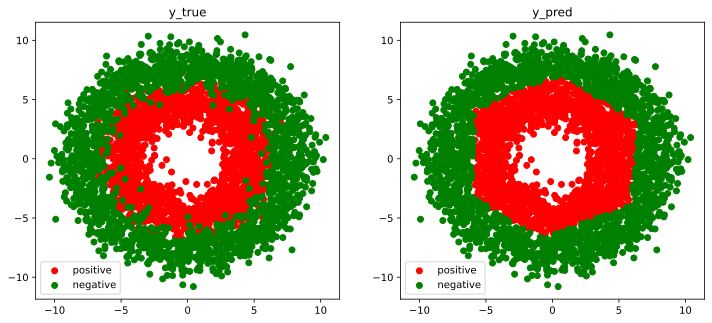

In [84]:
# 创建一个包含两个子图的图形窗口
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# 在第一个子图(ax1)上绘制真实标签的分布
ax1.scatter(Xp[:, 0], Xp[:, 1], c="r")  # 绘制正样本点，颜色为红色
ax1.scatter(Xn[:, 0], Xn[:, 1], c="g")  # 绘制负样本点，颜色为绿色
ax1.legend(["positive", "negative"])  # 添加图例标签
ax1.set_title("y_true")  # 设置子图标题为"y_true"

# 在第二个子图(ax2)上绘制模型的预测结果
Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]  # 获取模型预测为正样本的数据点
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]  # 获取模型预测为负样本的数据点

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c="r")  # 绘制模型预测为正样本的点，颜色为红色
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c="g")  # 绘制模型预测为负样本的点，颜色为绿色
ax2.legend(["positive", "negative"])  # 添加图例标签
ax2.set_title("y_pred")  # 设置子图标题为"y_pred"
